In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.display
import os
from scipy.io import wavfile
from scipy.signal import spectrogram

In [2]:
y_train = pd.read_csv("data/Y_train_ofTdMHi.csv")

# 1. EDA

## Analyze the target variable

In [3]:
y_train.head()

,id,pos_label
0,00000-JAM.wav,0.0
1,00001-JAM.wav,1.0
2,00002-JAM.wav,1.0
3,00003-JAM.wav,1.0
4,00004-JAM.wav,1.0


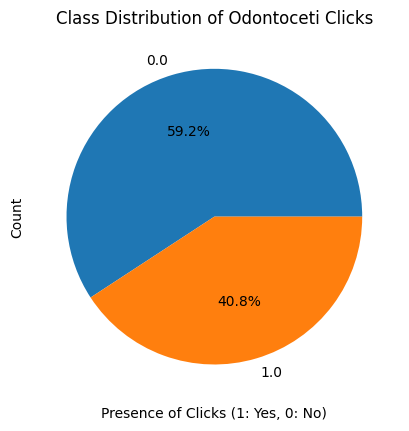

In [4]:
#Visualize the repartition of the target variable 
y_train['pos_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Class Distribution of Odontoceti Clicks")
plt.xlabel("Presence of Clicks (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()


In [5]:
# Extract location information from file names
y_train["location"] = y_train["id"].apply(lambda x: x.split("-")[-1].split(".")[0])

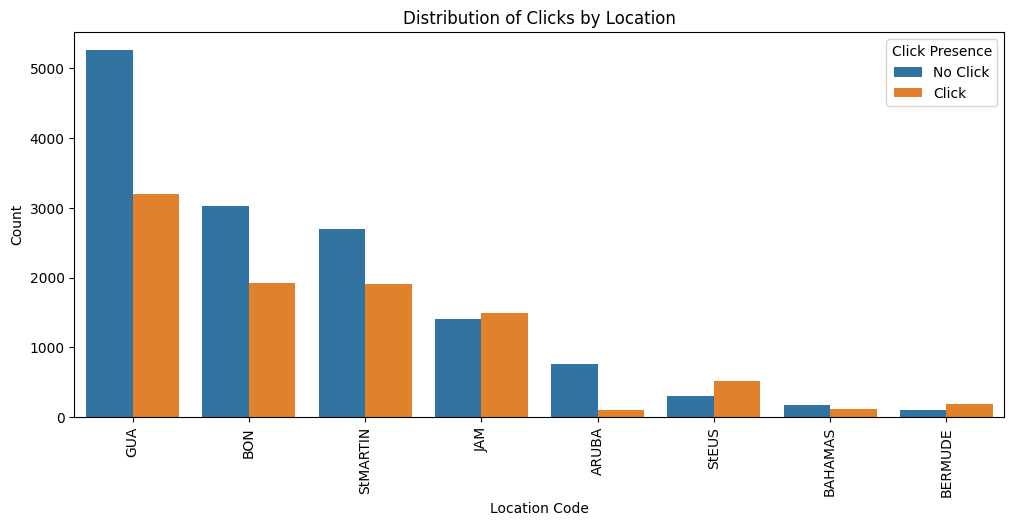

In [6]:
# Location-based distribution plot
plt.figure(figsize=(12, 5))
sns.countplot(x=y_train["location"], hue=y_train["pos_label"], order=y_train["location"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Clicks by Location")
plt.xlabel("Location Code")
plt.ylabel("Count")
plt.legend(title="Click Presence", labels=["No Click", "Click"])
plt.show()

Certain locations may have more odontoceti clicks, indicating regional differences in marine life activity.

## Audio Data Exploration

In [29]:
#Load audio files
audio_files = [os.path.join("data/X_train", f) for f in os.listdir("data/X_train") if f.endswith(".wav")]

audio_data = {}
for file in audio_files:
    y, sr = librosa.load(file, sr=None)  # Load with original sampling rate
    audio_data[file] = (y, sr)

# Extract basic properties
audio_properties = []
for file, (y, sr) in audio_data.items():
    duration = len(y) / sr
    min_amplitude = np.min(y)
    max_amplitude = np.max(y)
    audio_properties.append([file, sr, duration, min_amplitude, max_amplitude])

audio_df = pd.DataFrame(audio_properties, columns=["File", "Sampling Rate (Hz)", "Duration (s)", "Min Amplitude", "Max Amplitude"])


In [31]:
audio_df.head()

,File,Sampling Rate (Hz),Duration (s),Min Amplitude,Max Amplitude
0,data/X_train/09053-StMARTIN.wav,256000,0.2,-0.022705,0.038605
1,data/X_train/03617-StMARTIN.wav,256000,0.2,-0.016846,0.013397
2,data/X_train/13702-GUA.wav,256000,0.2,-0.017029,0.028564
3,data/X_train/02317-StMARTIN.wav,256000,0.2,-0.013611,0.007751
4,data/X_train/08553-StMARTIN.wav,256000,0.2,-0.018677,0.016663


In [32]:
# prendre le dernier élément
audio_df['File'] = audio_df['File'].str.split('/').str[-1]

In [33]:
audio_df.head()

,File,Sampling Rate (Hz),Duration (s),Min Amplitude,Max Amplitude
0,09053-StMARTIN.wav,256000,0.2,-0.022705,0.038605
1,03617-StMARTIN.wav,256000,0.2,-0.016846,0.013397
2,13702-GUA.wav,256000,0.2,-0.017029,0.028564
3,02317-StMARTIN.wav,256000,0.2,-0.013611,0.007751
4,08553-StMARTIN.wav,256000,0.2,-0.018677,0.016663


In [34]:
# Fusionner les deux DataFrames
merged_df = pd.merge(audio_df, y_train, left_on='File', right_on='id', how='inner')

In [37]:
merged_df.dtypes

File                   object
Sampling Rate (Hz)      int64
Duration (s)          float64
Min Amplitude         float32
Max Amplitude         float32
id                     object
pos_label             float64
location               object
dtype: object

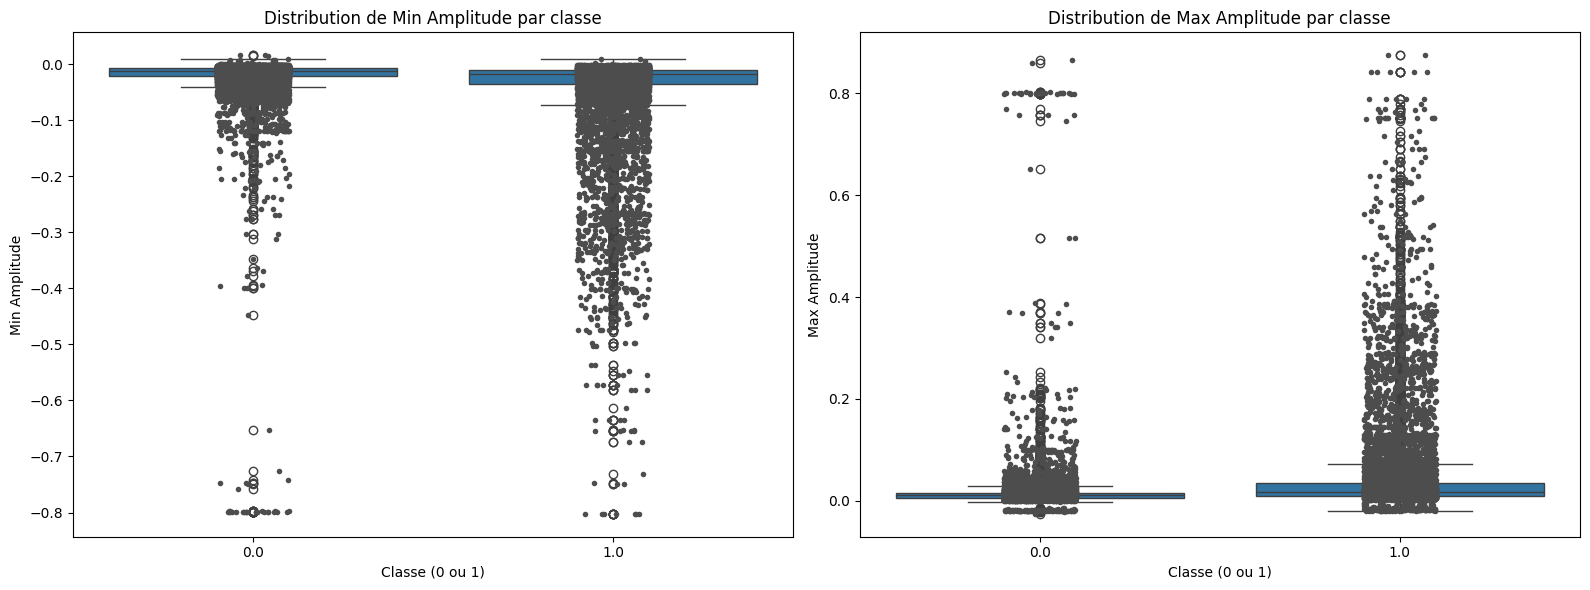

Statistiques pour Min Amplitude:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0 -0.019066  0.042905 -0.799225 -0.020325 -0.012146   
1.0         9450.0 -0.044168  0.079651 -0.802216 -0.034973 -0.018356   

                75%       max  
pos_label                      
0.0       -0.006927  0.015808  
1.0       -0.009613  0.008514  

Statistiques pour Max Amplitude:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.014693  0.042498 -0.025574  0.006317  0.010773   
1.0         9450.0  0.046285  0.092428 -0.021057  0.009468  0.017792   

                75%       max  
pos_label                      
0.0        0.015068  0.864441  
1.0        0.034378  0.874664  


In [39]:
# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution de Min_Amplitude par pos_label
sns.boxplot(x='pos_label', y='Min Amplitude', data=merged_df, ax=axes[0])
sns.stripplot(x='pos_label', y='Min Amplitude', data=merged_df, 
              size=4, color='.3', linewidth=0, ax=axes[0])
axes[0].set_title('Distribution de Min Amplitude par classe')
axes[0].set_xlabel('Classe (0 ou 1)')
axes[0].set_ylabel('Min Amplitude')

# Distribution de Max_Amplitude par pos_label
sns.boxplot(x='pos_label', y='Max Amplitude', data=merged_df, ax=axes[1])
sns.stripplot(x='pos_label', y='Max Amplitude', data=merged_df, 
              size=4, color='.3', linewidth=0, ax=axes[1])
axes[1].set_title('Distribution de Max Amplitude par classe')
axes[1].set_xlabel('Classe (0 ou 1)')
axes[1].set_ylabel('Max Amplitude')

plt.tight_layout()
plt.show()

# Vous pouvez aussi afficher quelques statistiques descriptives
print("Statistiques pour Min Amplitude:")
print(merged_df.groupby('pos_label')['Min Amplitude'].describe())
print("\nStatistiques pour Max Amplitude:")
print(merged_df.groupby('pos_label')['Max Amplitude'].describe())

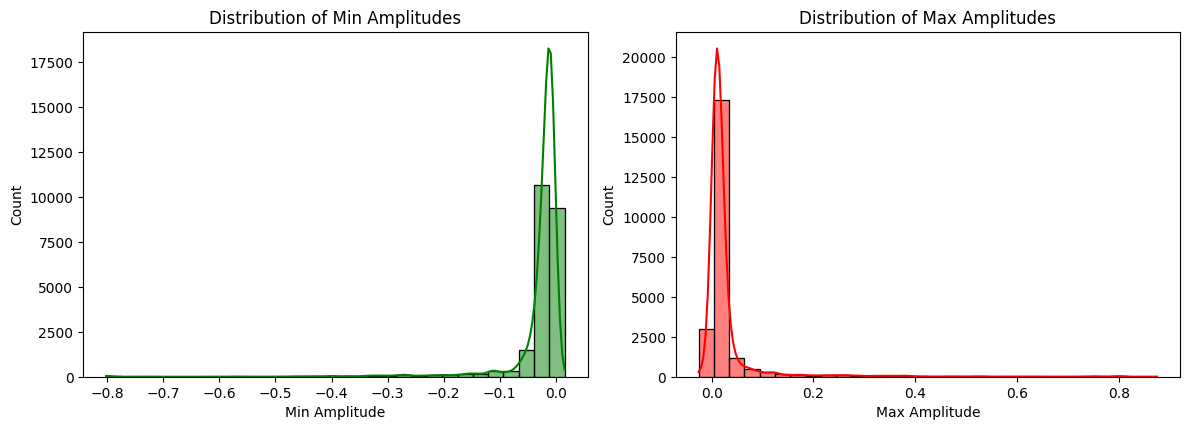

In [30]:
plt.figure(figsize=(12, 8))

# Min Amplitude distribution
plt.subplot(2, 2, 1)
sns.histplot(audio_df["Min Amplitude"], bins=30, kde=True, color="green")
plt.xlabel("Min Amplitude")
plt.ylabel("Count")
plt.title("Distribution of Min Amplitudes")

# Max Amplitude distribution
plt.subplot(2, 2, 2)
sns.histplot(audio_df["Max Amplitude"], bins=30, kde=True, color="red")
plt.xlabel("Max Amplitude")
plt.ylabel("Count")
plt.title("Distribution of Max Amplitudes")

plt.tight_layout()
plt.show()


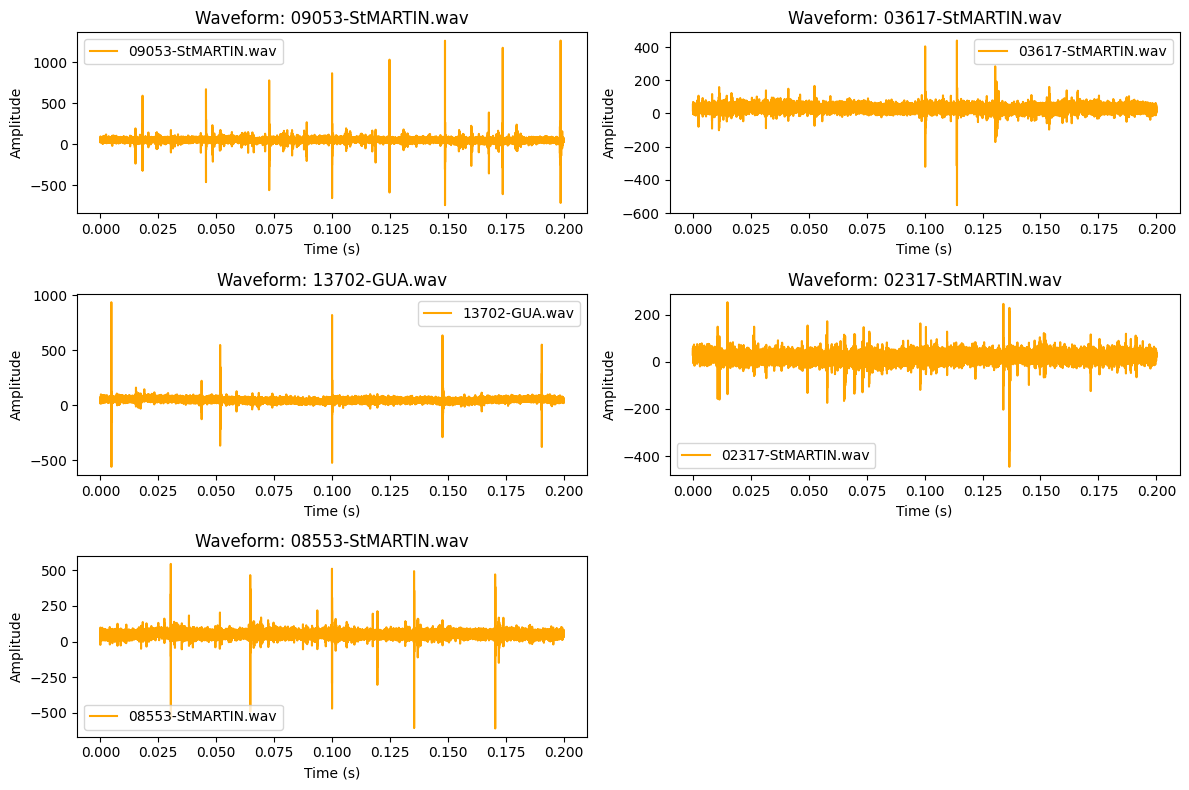

In [12]:
# Select a subset of files for visualization (first 5 files)
subset_files = audio_files[:5]

# Plot waveforms
plt.figure(figsize=(12, 8))
for i, file in enumerate(subset_files):
    sr, y = wavfile.read(file)
    time = np.linspace(0, len(y) / sr, num=len(y))
    
    plt.subplot(3, 2, i + 1)
    plt.plot(time, y, label=os.path.basename(file), color="orange")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform: {os.path.basename(file)}")
    plt.legend()

plt.tight_layout()
plt.show()


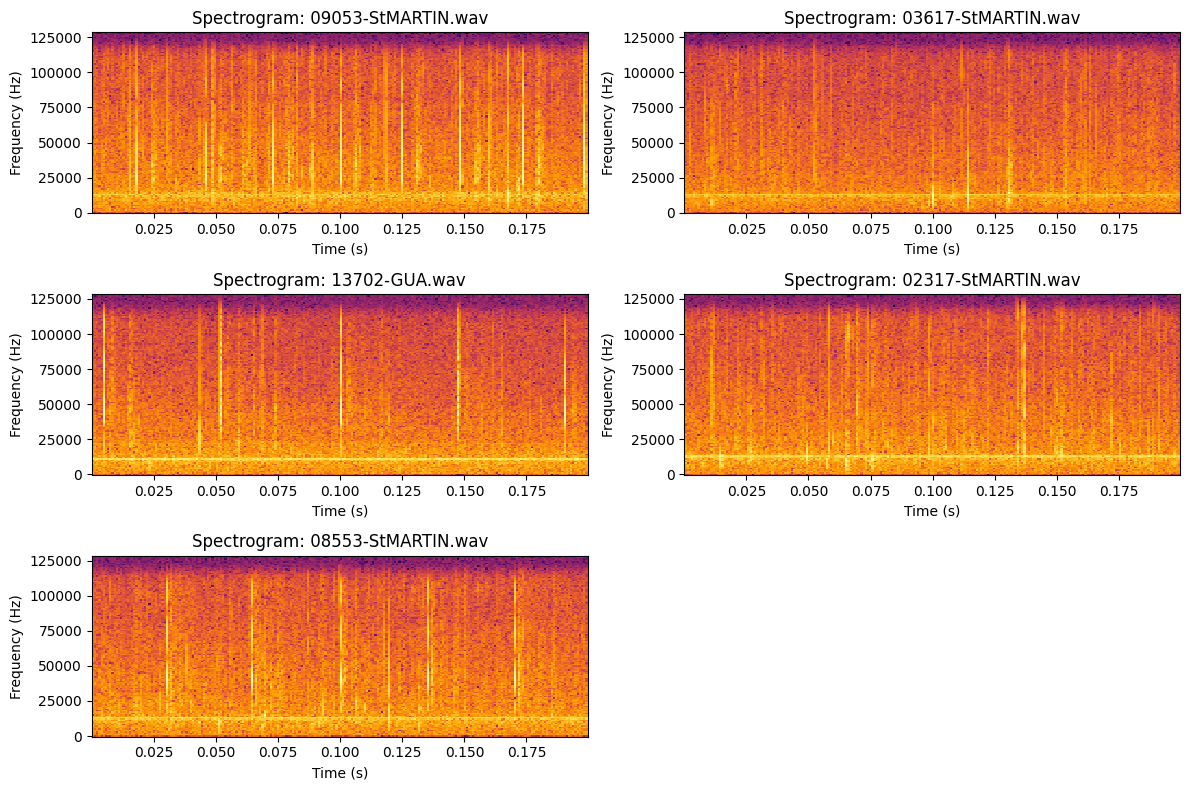

In [13]:
# Compute and display spectrograms for a subset of audio files
plt.figure(figsize=(12, 8))

for i, file in enumerate(subset_files):
    sr, y = wavfile.read(file)
    f, t, Sxx = spectrogram(y, fs=sr)
    
    plt.subplot(3, 2, i + 1)
    plt.pcolormesh(t, f, np.log(Sxx + 1e-10), shading='auto', cmap="inferno")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"Spectrogram: {os.path.basename(file)}")

plt.tight_layout()
plt.show()


## Feature extraction

 - Spectral Centroid: Measures the center of mass of the spectrum, indicating "brightness" of the sound.
 - Spectral Bandwidth: Measures how spread out the spectrum is around the centroid.
 - Zero-Crossing Rate (ZCR): Counts how often the signal crosses zero; useful for detecting transients
 - MFCCs (Mel Frequency Cepstral Coefficients): Captures sound characteristics in a compressed way, useful for classification.
 - Spectrogram Analysis: Provides a visual representation of frequency content over time.
 - RMS Energy: Measures the overall power of the audio signal, representing its loudness and intensity.
 - Spectral Flatness: Quantifies how noise-like or tone-like a sound is; a high value indicates noise, while a low value suggests tonal structure.


In [28]:
# Compute statistical aggregations for extracted features
extended_features = []

for file in audio_files:
    sr, y = wavfile.read(file)
    
    # Apply Bandpass Filter (5000Hz - 100kHz)
    sos = signal.butter(6, [5000, 100000], 'bandpass', fs=sr, output='sos')
    y_filtered = signal.sosfiltfilt(sos, y)
    
    # Compute RMS Energy statistics
    rms_values = np.sqrt(y_filtered**2)
    rms_mean, rms_std, rms_min, rms_max = np.mean(rms_values), np.std(rms_values), np.min(rms_values), np.max(rms_values)
    
    # Compute Spectral Centroid statistics
    f, t, Sxx = spectrogram(y_filtered, fs=sr)
    spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
    sc_mean, sc_std, sc_min, sc_max = np.mean(spectral_centroid), np.std(spectral_centroid), np.min(spectral_centroid), np.max(spectral_centroid)
    
    # Compute Spectral Bandwidth statistics
    spectral_bandwidth = np.std(f[:, None] * Sxx, axis=0)
    sb_mean, sb_std, sb_min, sb_max = np.mean(spectral_bandwidth), np.std(spectral_bandwidth), np.min(spectral_bandwidth), np.max(spectral_bandwidth)
    
    # Compute Spectral Flatness statistics
    spectral_flatness = 10 * np.log10(np.var(Sxx, axis=0) / np.mean(Sxx, axis=0))
    sf_mean, sf_std, sf_min, sf_max = np.mean(spectral_flatness), np.std(spectral_flatness), np.min(spectral_flatness), np.max(spectral_flatness)
    
    # Compute Zero-Crossing Rate statistics
    zcr_values = np.diff(np.sign(y_filtered)) != 0
    zcr_mean, zcr_std, zcr_min, zcr_max = np.mean(zcr_values), np.std(zcr_values), np.min(zcr_values), np.max(zcr_values)
    
    # Approximate MFCCs using FFT
    mfccs = np.abs(np.fft.fft(y_filtered))[:13]  # Extract first 13 coefficients
    mfccs_mean, mfccs_std, mfccs_min, mfccs_max = np.mean(mfccs), np.std(mfccs), np.min(mfccs), np.max(mfccs)
    extended_features.append([file, sr, rms_mean, rms_std, rms_min, rms_max,
                              sc_mean, sc_std, sc_min, sc_max, sb_mean, sb_std, sb_min, sb_max,
                              sf_mean, sf_std, sf_min, sf_max, zcr_mean, zcr_std, zcr_min, zcr_max,
                              mfccs_mean, mfccs_std, mfccs_min, mfccs_max])

columns = ["File", "Sampling Rate (Hz)", 
           "RMS_Mean", "RMS_Std", "RMS_Min", "RMS_Max", 
           "Spectral_Centroid_Mean", "Spectral_Centroid_Std", "Spectral_Centroid_Min", "Spectral_Centroid_Max",
           "Spectral_Bandwidth_Mean", "Spectral_Bandwidth_Std", "Spectral_Bandwidth_Min", "Spectral_Bandwidth_Max",
           "Spectral_Flatness_Mean", "Spectral_Flatness_Std", "Spectral_Flatness_Min", "Spectral_Flatness_Max",
           "ZCR_Mean", "ZCR_Std", "ZCR_Min", "ZCR_Max",
           "MFCC_Mean", "MFCC_Std", "MFCC_Min", "MFCC_Max"]

features_df = pd.DataFrame(extended_features, columns=columns)
features_df.head()


NameError: name 'signal' is not defined

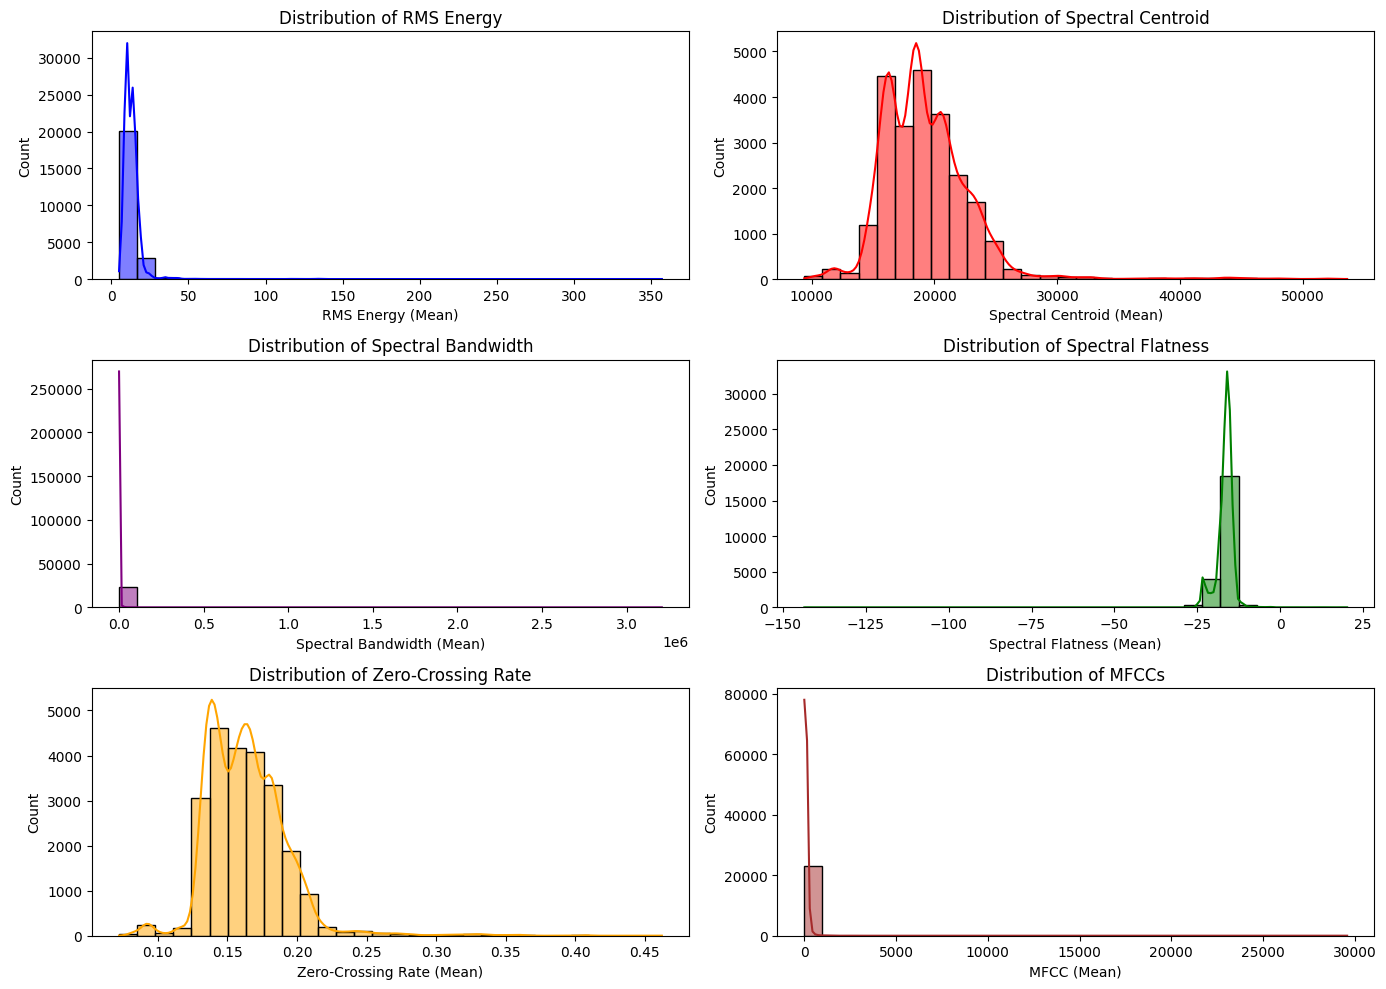

In [40]:
# Visualize feature distributions
plt.figure(figsize=(14, 10))

# RMS Energy distribution
plt.subplot(3, 2, 1)
sns.histplot(features_df["RMS_Mean"], bins=30, kde=True, color="blue")
plt.xlabel("RMS Energy (Mean)")
plt.ylabel("Count")
plt.title("Distribution of RMS Energy")

# Spectral Centroid distribution
plt.subplot(3, 2, 2)
sns.histplot(features_df["Spectral_Centroid_Mean"], bins=30, kde=True, color="red")
plt.xlabel("Spectral Centroid (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Spectral Centroid")

# Spectral Bandwidth distribution
plt.subplot(3, 2, 3)
sns.histplot(features_df["Spectral_Bandwidth_Mean"], bins=30, kde=True, color="purple")
plt.xlabel("Spectral Bandwidth (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Spectral Bandwidth")

# Spectral Flatness distribution
plt.subplot(3, 2, 4)
sns.histplot(features_df["Spectral_Flatness_Mean"], bins=30, kde=True, color="green")
plt.xlabel("Spectral Flatness (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Spectral Flatness")

# Zero-Crossing Rate distribution
plt.subplot(3, 2, 5)
sns.histplot(features_df["ZCR_Mean"], bins=30, kde=True, color="orange")
plt.xlabel("Zero-Crossing Rate (Mean)")
plt.ylabel("Count")
plt.title("Distribution of Zero-Crossing Rate")

# MFCC Mean distribution
plt.subplot(3, 2, 6)
sns.histplot(features_df["MFCC_Mean"], bins=30, kde=True, color="brown")
plt.xlabel("MFCC (Mean)")
plt.ylabel("Count")
plt.title("Distribution of MFCCs")

plt.tight_layout()
plt.show()


In [14]:
from scipy.stats import kurtosis, skew

In [15]:

# Charger les fichiers audio
audio_files = [os.path.join("data/X_train", f) for f in os.listdir("data/X_train") if f.endswith(".wav")]

audio_properties = []

for file in audio_files:
    y, sr = librosa.load(file, sr=None)

    # Spectral features
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    
    # FFT pour trouver la fréquence de pic
    D = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    peak_freq = freqs[np.argmax(np.mean(D, axis=1))]

    # Inter-Click Interval (ICI)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    ici_values = np.diff(onset_times)
    mean_ici = np.mean(ici_values) if len(ici_values) > 0 else 0

    # Durée
    click_duration = len(y) / sr  

    # Signal-to-Noise Ratio (SNR)
    signal_power = np.mean(y**2)
    noise_power = np.var(y)
    snr = 10 * np.log10(signal_power / noise_power)

    # Kurtosis & Skewness du spectre
    spec = np.abs(librosa.stft(y))
    spec_mean = np.mean(spec, axis=1)
    kurt = kurtosis(spec_mean)
    skewness = skew(spec_mean)

    # Stocker les propriétés
    audio_properties.append([
        file, sr, click_duration, spectral_bandwidth, peak_freq, mean_ici, snr, kurt, skewness
    ])

# Créer un DataFrame
columns = ["File", "Sampling Rate (Hz)", "Click Duration (s)", "Spectral Bandwidth", "Peak Frequency",
           "Mean ICI (s)", "SNR (dB)", "Kurtosis", "Skewness"]

audio_df = pd.DataFrame(audio_properties, columns=columns)

# Afficher un aperçu
print(audio_df.head())


/Users/maro/projet_dl/venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/Users/maro/projet_dl/venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


                              File  Sampling Rate (Hz)  Click Duration (s)  \
0  data/X_train/09053-StMARTIN.wav              256000                 0.2   
1  data/X_train/03617-StMARTIN.wav              256000                 0.2   
2       data/X_train/13702-GUA.wav              256000                 0.2   
3  data/X_train/02317-StMARTIN.wav              256000                 0.2   
4  data/X_train/08553-StMARTIN.wav              256000                 0.2   

   Spectral Bandwidth  Peak Frequency  Mean ICI (s)  SNR (dB)    Kurtosis  \
0        30318.865438             0.0      0.061333  5.917606  637.376038   
1        30840.690974             0.0      0.064000  5.248095  568.235229   
2        29284.781331             0.0      0.046500  8.178938  650.869080   
3        31134.621750             0.0      0.048500  3.380404  473.605042   
4        31179.332998             0.0      0.050667  8.017726  646.328796   

    Skewness  
0  24.178423  
1  22.366589  
2  24.622904  
3  19.85

In [17]:
audio_df.head()

,File,Sampling Rate (Hz),Click Duration (s),Spectral Bandwidth,Peak Frequency,Mean ICI (s),SNR (dB),Kurtosis,Skewness
0,data/X_train/09053-StMARTIN.wav,256000,0.2,30318.865438,0.0,0.061333,5.917606,637.376038,24.178423
1,data/X_train/03617-StMARTIN.wav,256000,0.2,30840.690974,0.0,0.064000,5.248095,568.235229,22.366589
2,data/X_train/13702-GUA.wav,256000,0.2,29284.781331,0.0,0.046500,8.178938,650.869080,24.622904
3,data/X_train/02317-StMARTIN.wav,256000,0.2,31134.621750,0.0,0.048500,3.380404,473.605042,19.853598
4,data/X_train/08553-StMARTIN.wav,256000,0.2,31179.332998,0.0,0.050667,8.017726,646.328796,24.482790


In [18]:
audio_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sampling Rate (Hz),23168.0,256000.000000,0.000000,256000.000000,256000.000000,256000.000000,256000.000000,256000.000000
Click Duration (s),23168.0,0.200000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
Spectral Bandwidth,23168.0,28944.506225,2770.134452,7012.878012,28298.644560,29161.023563,30191.157945,44266.466811
Peak Frequency,23168.0,146.586887,1426.668047,0.000000,0.000000,0.000000,0.000000,52000.000000
Mean ICI (s),23168.0,0.055706,0.013815,0.000000,0.046000,0.053333,0.061333,0.180000
SNR (dB),23168.0,7.406848,5.248986,0.000001,2.634824,8.522837,10.620104,35.796864
Kurtosis,23168.0,575.947754,145.584366,4.627418,545.017365,647.694550,661.952682,689.467224
Skewness,23168.0,22.470638,4.300125,1.773408,21.730649,24.525545,24.904695,25.664991


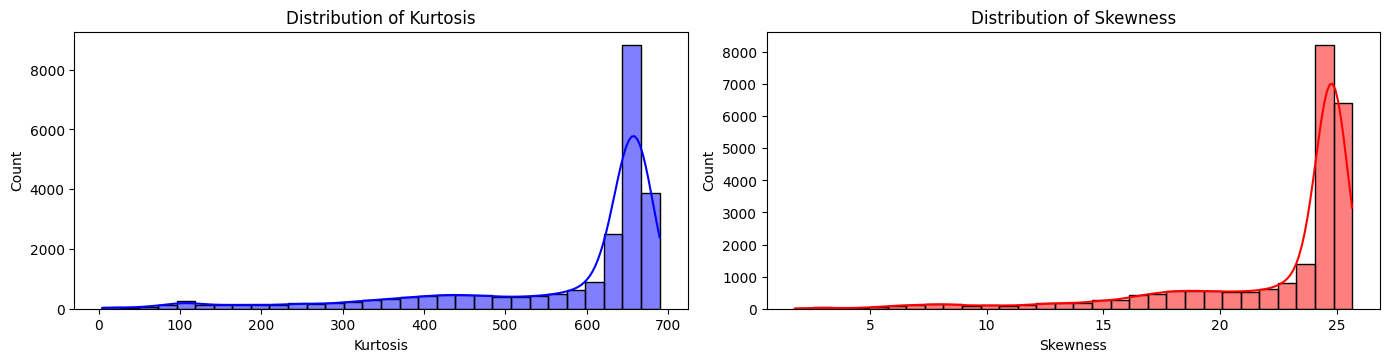

In [25]:
# Visualize feature distributions
plt.figure(figsize=(14, 10))

# RMS Energy distribution
plt.subplot(3, 2, 1)
sns.histplot(audio_df["Kurtosis"], bins=30, kde=True, color="blue")
plt.xlabel("Kurtosis")
plt.ylabel("Count")
plt.title("Distribution of Kurtosis")

# Spectral Centroid distribution
plt.subplot(3, 2, 2)
sns.histplot(audio_df["Skewness"], bins=30, kde=True, color="red")
plt.xlabel("Skewness")
plt.ylabel("Count")
plt.title("Distribution of Skewness")

plt.tight_layout()
plt.show()


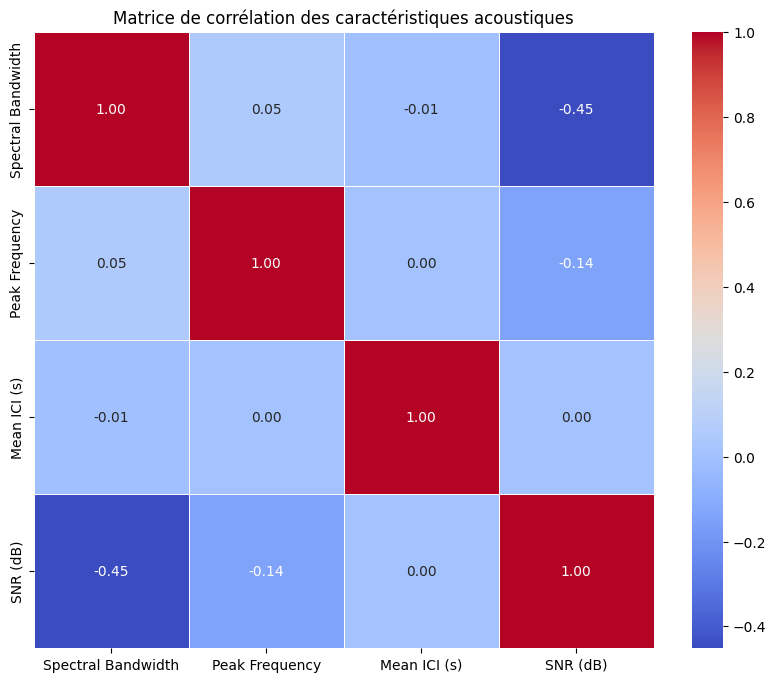

In [27]:
# Calculer la matrice de corrélation
corr_matrix = audio_df.drop(columns=["File","Skewness","Kurtosis","Sampling Rate (Hz)","Click Duration (s)"]).corr()

# Afficher la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation des caractéristiques acoustiques")
plt.show()


Pour chaque trame de 2048 échantillons, le programme extrait les caractéristiques suivantes :
Puissant RMS
Centroïde spectrale (spectral centroid) 
Largeur spectrale (spectral bandwith)
Platitude spectrale (spectral flatness)
Le programme calcule ensuite : la moyenne, l'écart-type, le min, le max pour l'ensemble des trames d'un signal.

In [8]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew


In [10]:
# Charger les fichiers audio
audio_files = [os.path.join("data/X_train", f) for f in os.listdir("data/X_train") if f.endswith(".wav")]

audio_properties = []

for file in audio_files:
    y, sr = librosa.load(file, sr=None)

    # Puissance RMS
    rms = librosa.feature.rms(y=y)
    rms_mean, rms_std, rms_min, rms_max = np.mean(rms), np.std(rms), np.min(rms), np.max(rms)

    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean, centroid_std, centroid_min, centroid_max = np.mean(centroid), np.std(centroid), np.min(centroid), np.max(centroid)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max = np.mean(bandwidth), np.std(bandwidth), np.min(bandwidth), np.max(bandwidth)

    # Spectral Flatness
    flatness = librosa.feature.spectral_flatness(y=y)
    flatness_mean, flatness_std, flatness_min, flatness_max = np.mean(flatness), np.std(flatness), np.min(flatness), np.max(flatness)

    # FFT pour trouver la fréquence de pic
    D = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    peak_freq = freqs[np.argmax(np.mean(D, axis=1))]

    # Inter-Click Interval (ICI)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    ici_values = np.diff(onset_times)
    mean_ici = np.mean(ici_values) if len(ici_values) > 0 else 0

    # Signal-to-Noise Ratio (SNR)
    signal_power = np.mean(y**2)
    noise_power = np.var(y)
    snr = 10 * np.log10(signal_power / noise_power)

    # Kurtosis & Skewness du spectre
    spec = np.abs(librosa.stft(y))
    spec_mean = np.mean(spec, axis=1)
    kurt = kurtosis(spec_mean)
    skewness = skew(spec_mean)

    # Stocker les propriétés
    audio_properties.append([
        file, sr, click_duration, peak_freq, mean_ici, snr, kurt, skewness,
        rms_mean, rms_std, rms_min, rms_max,
        centroid_mean, centroid_std, centroid_min, centroid_max,
        bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max,
        flatness_mean, flatness_std, flatness_min, flatness_max
    ])

# Créer un DataFrame
columns = [
    "File", "Sampling Rate (Hz)", "Click Duration (s)", "Peak Frequency", "Mean ICI (s)", "SNR (dB)", "Kurtosis", "Skewness",
    "RMS Mean", "RMS Std", "RMS Min", "RMS Max",
    "Spectral Centroid Mean", "Spectral Centroid Std", "Spectral Centroid Min", "Spectral Centroid Max",
    "Spectral Bandwidth Mean", "Spectral Bandwidth Std", "Spectral Bandwidth Min", "Spectral Bandwidth Max",
    "Spectral Flatness Mean", "Spectral Flatness Std", "Spectral Flatness Min", "Spectral Flatness Max"
]

audio_df = pd.DataFrame(audio_properties, columns=columns)



In [12]:
audio_df.head()

,File,Sampling Rate (Hz),Click Duration (s),Peak Frequency,Mean ICI (s),SNR (dB),Kurtosis,Skewness,RMS Mean,RMS Std,...,Spectral Centroid Min,Spectral Centroid Max,Spectral Bandwidth Mean,Spectral Bandwidth Std,Spectral Bandwidth Min,Spectral Bandwidth Max,Spectral Flatness Mean,Spectral Flatness Std,Spectral Flatness Min,Spectral Flatness Max
0,data/X_train/09053-StMARTIN.wav,256000,0.2,0.0,0.061333,5.917606,637.376038,24.178423,0.001732,0.000165,...,26640.654909,47777.718189,30318.865438,1856.445460,26283.129677,34609.531409,0.026990,0.030033,0.005673,0.181438
1,data/X_train/03617-StMARTIN.wav,256000,0.2,0.0,0.064000,5.248095,568.235229,22.366589,0.001105,0.000144,...,23615.569174,37871.395905,30840.690974,1812.133145,22773.206853,33808.041229,0.019188,0.008159,0.007842,0.051161
2,data/X_train/13702-GUA.wav,256000,0.2,0.0,0.046500,8.178938,650.869080,24.622904,0.001536,0.000221,...,20232.889015,56522.890799,29284.781331,1552.853267,27371.481394,35056.916436,0.011727,0.020408,0.001645,0.103085
3,data/X_train/02317-StMARTIN.wav,256000,0.2,0.0,0.048500,3.380404,473.605042,19.853598,0.000858,0.000096,...,27567.683469,47570.451099,31134.621750,1557.783701,27539.355304,36475.940302,0.040512,0.027412,0.013578,0.150693
4,data/X_train/08553-StMARTIN.wav,256000,0.2,0.0,0.050667,8.017726,646.328796,24.482790,0.001669,0.000152,...,25049.413416,49842.297873,31179.332998,891.815777,28182.790293,33287.221532,0.013907,0.013774,0.004108,0.063531


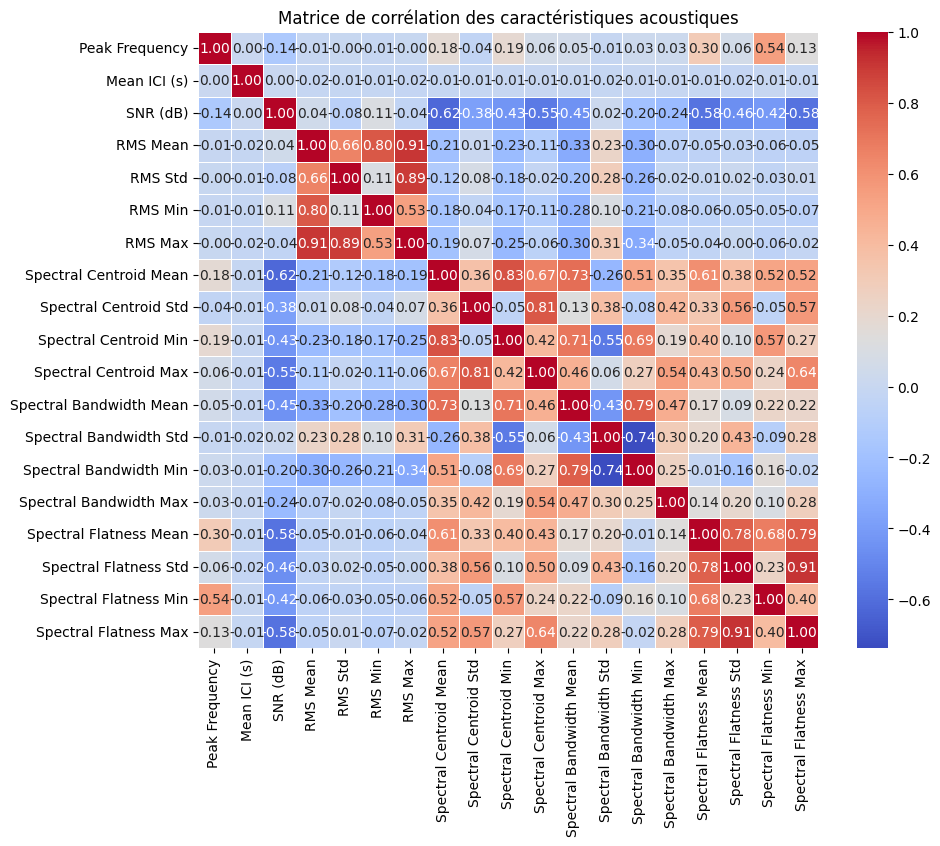

In [13]:
# Calculer la matrice de corrélation
corr_matrix = audio_df.drop(columns=["File","Skewness","Kurtosis","Sampling Rate (Hz)","Click Duration (s)"]).corr()

# Afficher la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation des caractéristiques acoustiques")
plt.show()

In [ ]:


# Charger les fichiers audio
audio_files = [os.path.join("data/X_train", f) for f in os.listdir("data/X_train") if f.endswith(".wav")]

audio_properties = []

for file in audio_files:
    y, sr = librosa.load(file, sr=None)

    # Fonction générique pour extraire stats : mean, std, min, max
    def extract_stats(feature):
        return np.mean(feature), np.std(feature), np.min(feature), np.max(feature)

    # Puissance RMS (Root Mean Square)
    rms = librosa.feature.rms(y=y)
    rms_mean, rms_std, rms_min, rms_max = extract_stats(rms)

    # Centroïde spectral
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean, centroid_std, centroid_min, centroid_max = extract_stats(centroid)

    # Largeur spectrale
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max = extract_stats(bandwidth)

    # Platitude spectrale
    flatness = librosa.feature.spectral_flatness(y=y)
    flatness_mean, flatness_std, flatness_min, flatness_max = extract_stats(flatness)

    # FFT pour trouver la fréquence de pic
    D = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    peak_freq = freqs[np.argmax(np.mean(D, axis=1))]

    # Inter-Click Interval (ICI)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    ici_values = np.diff(onset_times)
    mean_ici = np.mean(ici_values) if len(ici_values) > 0 else 0


    # Signal-to-Noise Ratio (SNR)
    signal_power = np.mean(y**2)
    noise_power = np.var(y)
    snr = 10 * np.log10(signal_power / noise_power)

    # Kurtosis & Skewness du spectre
    spec = np.abs(librosa.stft(y))
    spec_mean = np.mean(spec, axis=1)
    kurt = kurtosis(spec_mean)
    skewness = skew(spec_mean)

    # Stocker les propriétés
    audio_properties.append([
        file, sr, click_duration, peak_freq, mean_ici, snr, kurt, skewness,
        rms_mean, rms_std, rms_min, rms_max,
        centroid_mean, centroid_std, centroid_min, centroid_max,
        bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max,
        flatness_mean, flatness_std, flatness_min, flatness_max
    ])

# Créer un DataFrame
columns = [
    "File", "Sampling Rate (Hz)", "Click Duration (s)", "Peak Frequency", "Mean ICI (s)", "SNR (dB)", "Kurtosis", "Skewness",
    "RMS Mean", "RMS Std", "RMS Min", "RMS Max",
    "Spectral Centroid Mean", "Spectral Centroid Std", "Spectral Centroid Min", "Spectral Centroid Max",
    "Spectral Bandwidth Mean", "Spectral Bandwidth Std", "Spectral Bandwidth Min", "Spectral Bandwidth Max",
    "Spectral Flatness Mean", "Spectral Flatness Std", "Spectral Flatness Min", "Spectral Flatness Max"
]

df = pd.DataFrame(audio_properties, columns=columns)

# Afficher un aperçu
print(auddf.head())
